In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
action_num = 12
state_num = 6

P_ij = np.array([[0.1,0.9,0,0,0,0],
                [0,0.1,0.9,0,0,0],
                [0,0,0.1,0.9,0,0],
                [0,0,0,0.1,0.9,0],
                [0,0,0,0,0.1,0.9],
                [0,0,0,0,0,1]]
                )

maitenance_index = action_num-1

In [3]:
P_aij = np.zeros((action_num,state_num,state_num))
def cal_P_aij(P_aij):
    for a in range(action_num):
        for i in range(state_num):
            for j in range(state_num):
                if a != maitenance_index and j>=i:  
                   P_aij[a][i][j] = P_ij[i][j]
                if a == maitenance_index and j==0:  
                   P_aij[a][i][j] = 1
    return P_aij

def get_next_state(state,action):
    state_list = [i for i in range(state_num)]
    weights = P_aij[action][state]
    next_state = random.choices(state_list, weights=weights, k=1)[0]
    return next_state

maintenance_cost = np.zeros((state_num,action_num))
def cal_maintenance_cost(maintenance_cost):
    maintenance_cost[1][maitenance_index] = 1.5
    maintenance_cost[2][maitenance_index] = 1.8
    maintenance_cost[3][maitenance_index] = 2.1
    maintenance_cost[4][maitenance_index] = 2.4
    maintenance_cost[5][maitenance_index] = 2.9
    maintenance_cost[0][maitenance_index] = 1

    return maintenance_cost

proc_cost = np.zeros((state_num,action_num))
def cal_proc_cost(proc_cost):
    for i in range(state_num-2): 
        proc_cost[i][:] = round(random.uniform(i,i+1),1)
    for i in range(state_num-2,state_num): 
        proc_cost[i][:] = round(random.uniform(i+2,i+3),1)
    proc_cost[5][:]=5.1
    return proc_cost

proc_time = np.zeros((action_num))
def cal_proc_time(proc_time):
    for a in range(action_num-1):
        proc_time[a] = round(random.uniform(0.8,2.6),1)
        # proc_time[a] = round(random.uniform(0.3,3.1),1)# increasing uncertainty, lower the efficiency of HR algorithm

    return proc_time

completion_reward = np.zeros((state_num,action_num))
def cal_completion_reward(completion_reward):
    for a in range(action_num-1):
        reward = round(random.uniform(1.1,3.4),1)
        # reward = round(random.uniform(0.5,4),1)# increasing uncertainty, lower the efficiency of HR algorithm
        for i in range(state_num): 
            completion_reward[i][a] = reward

    return completion_reward

def immediate_reward(state,action):
    return completion_reward[state][action] - maintenance_cost[state][action] - proc_cost[state][action]*proc_time[action]

## R-Learning

In [4]:
beta_1 = 0.1 # learning rate
def rel_avg_reward_updating(cur_state,action,next_state,avg_reward,rel_avg_reward):
    return (1-beta_1)*rel_avg_reward[cur_state][action] + beta_1*(immediate_reward(cur_state,action)-avg_reward+max(rel_avg_reward[next_state]))

beta_2 = 0.01 # learning rate    
def avg_reward_updating(cur_state,action,next_state,avg_reward,rel_avg_reward):
    return (1-beta_2)*avg_reward + beta_2*(immediate_reward(cur_state,action)+max(rel_avg_reward[next_state])-max(rel_avg_reward[cur_state]))

def iterative_R_alg(initial_state,iterative_num):
    k = 0
    eposilon = 0.9 # exploration factor
    phi = 1.005 # decaying factor
    avg_reward = 0
    rel_avg_reward = np.zeros((state_num,action_num))
    for i in range(state_num): 
        for a in range(action_num):
            rel_avg_reward[i][a] = immediate_reward(i,a)
    history_state_list = []
    history_action_list = []
    history_reward_list = []
    history_exp_avg_reward_list = []
    cur_state = initial_state
    next_state = 0
    action = 0

    while k<iterative_num:
        # step2
        eposilon = eposilon/phi

        # step3
        exploitation = random.choices([0,1], weights=[eposilon,1-eposilon], k=1)[0]
        if exploitation == 1 :
            action = np.argmax(rel_avg_reward[cur_state])
            next_state = get_next_state(cur_state,action)
            avg_reward = avg_reward_updating(cur_state,action,next_state,avg_reward,rel_avg_reward)
        else:
            action_candidate_list = [i for i in range(action_num) if i!=np.argmax(rel_avg_reward[cur_state])]
            action = random.choices(action_candidate_list, weights=[1/len(action_candidate_list) for i in range(len(action_candidate_list))], k=1)[0]
            next_state = get_next_state(cur_state,action)    

        rel_avg_reward[cur_state][action] = rel_avg_reward_updating(cur_state,action,next_state,avg_reward,rel_avg_reward)
        history_action_list.append(action)   
        history_state_list.append(next_state)
        history_reward_list.append(immediate_reward(cur_state,action))
        # print(immediate_reward(cur_state,action))
        history_exp_avg_reward_list.append(sum(history_reward_list)/len( history_reward_list))

        # step 5
        cur_state = next_state
        k += 1
        # print(avg_reward)
    return history_state_list, history_action_list, history_exp_avg_reward_list,rel_avg_reward

## GR-Learning

In [5]:
gamma = 1
def Q_value_updating(cur_state, action, next_state, Q, immediate_reward,rho):
    # Q 值的更新現在考慮了即時獎勵加上折扣後的後續狀態的最大 Q 值
    return (1 - beta_1) * Q[cur_state][action] + beta_1 * (immediate_reward(cur_state, action)- rho + gamma * np.max(Q[next_state]))

def epsilon_greedy_policy(state, Q, epsilon):
    # 使用 epsilon-greedy 策略選擇動作
    if random.uniform(0, 1) < epsilon:
        return random.randint(0, action_num - 1)
    else:
        return np.argmax(Q[state])

def iterative_GR_learning(initial_state, iterative_num):
    
    Q = np.zeros((state_num, action_num))
    epsilon = 0.9  # 探索因子
    avg_reward_list = []
    history_state_list = []
    history_action_list = []
    history_reward_list = []
    history_exp_avg_reward_list=[]
    rho = 0
    
    cur_state = initial_state
    for k in range(iterative_num):
        action = epsilon_greedy_policy(cur_state, Q, epsilon)
        next_state = get_next_state(cur_state, action)
        reward = immediate_reward(cur_state, action)
        
        Q[cur_state][action] = Q_value_updating(cur_state, action, next_state, Q, immediate_reward,rho)
        
        rho = (1-beta_2)*rho + beta_2*reward
        
        avg_reward_list.append(reward)
        history_state_list.append(cur_state)
        history_action_list.append(action)
        history_reward_list.append(reward)
        
        cur_state = next_state
        epsilon *= 1 / (1 + beta_2 * k)  # 隨著時間衰減的 epsilon
        
        history_exp_avg_reward_list.append(sum(history_reward_list)/len( history_reward_list))
        
    avg_reward = np.mean(avg_reward_list)
    
    return history_state_list, history_action_list, history_exp_avg_reward_list, avg_reward, Q

## HR-Learning

In [6]:
def eta_generate():
    return random.uniform(0,1)

def iterative_HR_alg(initial_state,iterative_num):
    k = 0
    eposilon = 0.9 # exploration factor
    eta_0 = 0.1 # trigger factor
    phi = 1.005 # decaying factor
    avg_reward = 0
    rel_avg_reward = np.zeros((state_num,action_num))
  
    for i in range(state_num): 
        for a in range(action_num):
            rel_avg_reward[i][a] = immediate_reward(i,a)
    
    history_state_list = []
    history_action_list = []
    history_reward_list = []
    history_exp_avg_reward_list = []
    cur_state = initial_state
    next_state = 0
    action = 0

    while k<iterative_num:
        # step2
        eta = eta_generate()
        eposilon = eposilon/phi

        # step3 
        if maintenance_cost[cur_state][maitenance_index] <= min(
            [(proc_cost[cur_state][action]*proc_time[action])-(completion_reward[cur_state][action]) for action in range(action_num-1)]) and eta>eta_0*(1-eposilon):
            action = maitenance_index
            next_state = 0
            rel_avg_reward[cur_state][action] = rel_avg_reward_updating(cur_state,action,next_state,avg_reward,rel_avg_reward)
            avg_reward = avg_reward_updating(cur_state,action,next_state,avg_reward,rel_avg_reward)

        else:
            # step 4
            exploitation = random.choices([0,1], weights=[eposilon,1-eposilon], k=1)[0]
            if exploitation == 1 :
                action = np.argmax(rel_avg_reward[cur_state])
                next_state = get_next_state(cur_state,action)
                avg_reward = avg_reward_updating(cur_state,action,next_state,avg_reward,rel_avg_reward)
            else:
                action_candidate_list = [i for i in range(action_num) if i!=np.argmax(rel_avg_reward[cur_state])]
                action = random.choices(action_candidate_list, weights=[1/len(action_candidate_list) for i in range(len(action_candidate_list))], k=1)[0]
                next_state = get_next_state(cur_state,action)

            # step 5
            rel_avg_reward[cur_state][action] = rel_avg_reward_updating(cur_state,action,next_state,avg_reward,rel_avg_reward)
        history_action_list.append(action)   
        history_state_list.append(next_state)
        history_reward_list.append(immediate_reward(cur_state,action))
        # print(immediate_reward(cur_state,action))
        history_exp_avg_reward_list.append(sum(history_reward_list)/len( history_reward_list))

        # step 6
        cur_state = next_state
        k += 1
        # print(avg_reward)
    return history_state_list, history_action_list, history_exp_avg_reward_list,rel_avg_reward

Q-table---HR
0.6 0.2 1.0 1.6 0.7 1.2 0.7 2.2 1.7 1.0 0.7 -0.1 
-0.8 -2.4 -1.9 -0.9 -0.7 -0.7 -1.1 -0.1 -1.0 -1.4 -2.2 -0.5 
-1.3 -3.6 -3.0 -1.9 -1.0 -1.2 -1.8 -1.2 -1.8 -2.5 -3.4 0.2 
-2.4 -6.8 -6.8 -5.4 -2.1 -3.2 -3.6 -3.9 -5.1 -5.9 -7.4 -0.3 
-4.9 -13.3 -13.8 -11.3 -4.1 -7.3 -7.8 -9.5 -11.2 -11.4 -14.6 -0.6 
-3.4 -9.5 -9.7 -7.7 -2.8 -4.9 -5.4 -6.3 -7.6 -8.0 -10.4 -2.9 
Q-table---R
0.8 0.6 1.0 1.5 0.8 1.3 0.8 2.3 1.5 1.2 1.0 -0.4 
-0.9 -2.7 -2.1 -1.2 -0.9 -0.9 -1.2 -0.8 -1.0 -1.6 -2.3 -1.1 
-1.4 -3.1 -3.0 -1.6 -0.7 -1.3 -1.5 -1.3 -1.9 -2.2 -3.2 -1.2 
-2.7 -7.0 -6.7 -5.6 -2.4 -3.3 -3.6 -4.1 -5.1 -5.7 -7.5 -0.1 
-5.1 -13.3 -13.8 -11.5 -4.1 -7.3 -8.3 -9.8 -11.4 -12.2 -14.6 -0.9 
-3.9 -10.0 -9.7 -8.2 -3.3 -5.9 -6.2 -6.7 -7.9 -8.5 -10.9 -1.6 
Q-table---GR Learning
0.1 0.0 0.0 4.8 0.0 0.1 0.0 0.0 0.0 0.0 0.0 -0.1 
-0.0 -0.2 -0.2 1.9 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
2.4 -0.6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.2 
-0.2 -0.6 -0.5 -0.4 -0.0 -0.2 -0.2 -0.2 -0.3 -0.4 -0.5 2.9 
-0.5 -1.3 -1.3 -

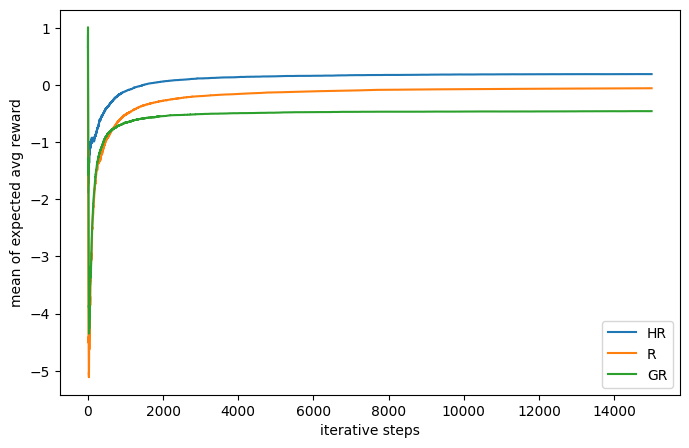

In [18]:
# maintenance_cost = cal_maintenance_cost(maintenance_cost)
# proc_cost = cal_proc_cost(proc_cost)
# proc_time = cal_proc_time(proc_time)
# completion_reward = cal_completion_reward(completion_reward)
# P_aij = cal_P_aij(P_aij)

iterative_num = 15000
plt.figure(figsize=(8,5))
history_state_list, history_action_list, history_exp_avg_reward_list, rel_avg_reward = iterative_HR_alg(0,iterative_num)
x = [i for i in range(iterative_num)]
y = history_exp_avg_reward_list
plt.plot(x,y, label='HR')

print("Q-table---HR")
for i in range(state_num): 
    for a in range(action_num):
        print(round(rel_avg_reward[i][a],1),end=" ")
    print("")


history_state_list, history_action_list, history_exp_avg_reward_list, rel_avg_reward = iterative_R_alg(0,iterative_num)
xx = [i for i in range(iterative_num)]
yy = history_exp_avg_reward_list
plt.xlabel('iterative steps')
plt.ylabel('mean of expected avg reward')
plt.plot(xx,yy, label='R')
plt.legend()

print("Q-table---R")
for i in range(state_num): 
    for a in range(action_num):
        print(round(rel_avg_reward[i][a],1),end=" ")
    print("")
    
history_state_list, history_action_list, history_exp_avg_cost_list, rel_avg_cost,Q = iterative_GR_learning(0, iterative_num)
xxx = [i for i in range(iterative_num)]
yyy = history_exp_avg_cost_list
plt.plot(xxx, yyy, label='GR')
plt.legend()

print("Q-table---GR Learning")
for i in range(state_num): 
    for a in range(action_num):
        print(f"{Q[i][a]:.1f}", end=" ")
    print("")

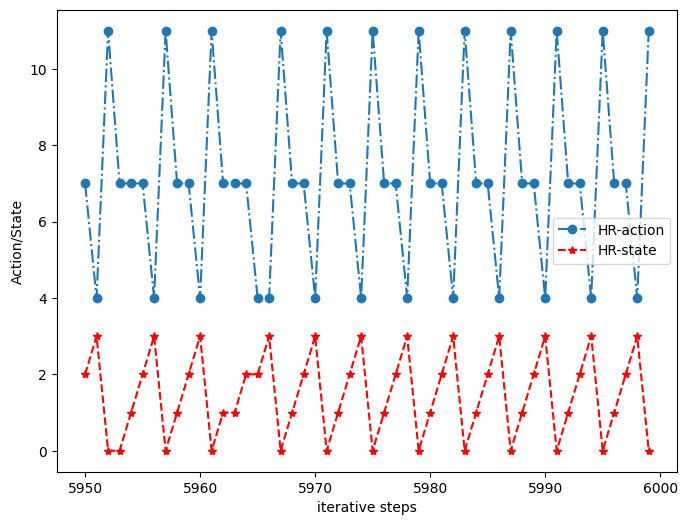

In [8]:
iterative_num = 6000
plt.figure(figsize=(8,6))
history_state_list, history_action_list3, history_exp_avg_reward_list,rel_avg_reward = iterative_HR_alg(0,iterative_num)
plt.plot(range(iterative_num-50,iterative_num), history_action_list3[-50:], "o",label='HR-action', linestyle='-.')
plt.plot(range(iterative_num-50,iterative_num), history_state_list[-50:], "*", label='HR-state', linestyle='--',color="red")
plt.xlabel('iterative steps')
plt.ylabel('Action/State')
plt.legend()

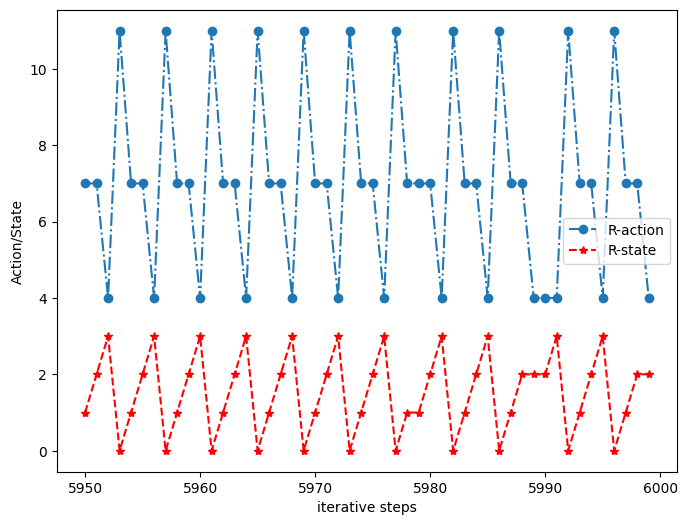

In [9]:
iterative_num = 6000
plt.figure(figsize=(8,6))
history_state_list, history_action_list1, history_exp_avg_reward_list,rel_avg_reward = iterative_R_alg(0,iterative_num)
plt.plot(range(iterative_num-50,iterative_num), history_action_list1[-50:], "o",label='R-action', linestyle='-.')
plt.plot(range(iterative_num-50,iterative_num), history_state_list[-50:], "*", label='R-state', linestyle='--',color="red")
plt.xlabel('iterative steps')
plt.ylabel('Action/State')
plt.legend()

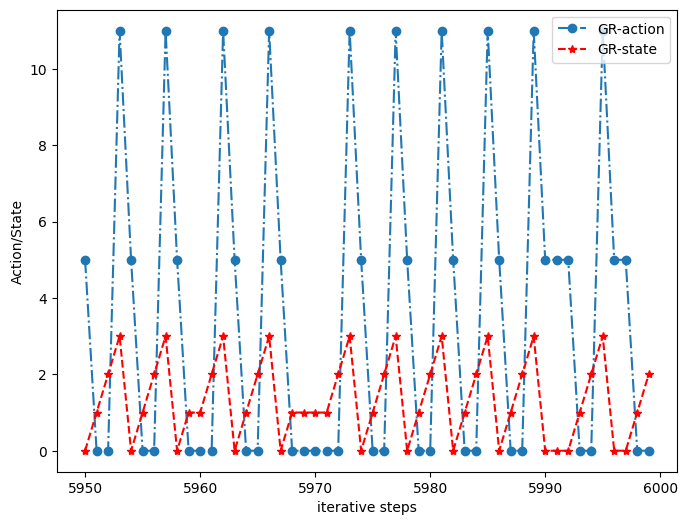

In [10]:
iterative_num = 6000
plt.figure(figsize=(8,6))
history_state_list, history_action_list2, history_exp_avg_cost_list, rel_avg_cost,Q = iterative_GR_learning(0, iterative_num)
plt.plot(range(iterative_num-50,iterative_num), history_action_list2[-50:], "o",label='GR-action', linestyle='-.')
plt.plot(range(iterative_num-50,iterative_num), history_state_list[-50:], "*", label='GR-state', linestyle='--',color="red")
plt.xlabel('iterative steps')
plt.ylabel('Action/State')
plt.legend()